In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.layers import NumericalMarkowitz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from os import path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
import yfinance as yf
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder
import os
from deepdow.layers import Conv
from deepdow.layers.collapse import AttentionCollapse, AverageCollapse
from deepdow.layers.misc import CovarianceMatrix
import h5py

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


In [2]:
import h5py
import torch
# 函数：向嵌套字典添加新值
def add_to_nested_dict(nested_dict, k1, k2, value):
    # 如果 k1 不存在，创建新的子字典
    if k1 not in nested_dict:
        nested_dict[k1] = {}
    
    # 如果 k2 不存在，创建新的列表
    if k2 not in nested_dict[k1]:
        nested_dict[k1][k2] = []
    
    # 将 value 追加到 k2 对应的列表
    nested_dict[k1][k2].append(value)
from datetime import datetime
all_content = {}
output_file = "hidden_states.h5"
with h5py.File(output_file, "r") as f_read:
    for k in f_read.keys():
        #print("文件中的键：", list(f_read[k]))
        for ds in list(f_read[k]):

            ts = datetime.strptime(ds.split("_")[-1], "%Y-%m-%d %H:%M:%S%z")
            day = str(ts.date())
            #print(day)
            # {k: {ts: f_read[k][ds][:]}}
            # all_content[k] = {ts.date():f_read[k][ds][:]}
            add_to_nested_dict(all_content, k, day, torch.tensor(f_read[k][ds][:]).to(torch.float))
        #data = f_read[k]['hidden_states_2005-10-13 19:00:40+00:00'][:]
        #break
def swap_hierarchy(A):
    """
    交换字典 A 的层级，从 {name: {timestamps: [value, value]}} 转换为
    {timestamps: {name: [value, value]}}.
    
    参数:
        A: 输入字典，结构为 {name: {timestamps: [value, value]}}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: {name: [value, value]}}
    """
    new_A = {}
    
    # 遍历原始字典
    for name, timestamp_dict in A.items():
        for timestamp, values in timestamp_dict.items():
            # 如果 timestamp 不在 new_A 中，初始化
            if timestamp not in new_A:
                new_A[timestamp] = {}
            # 将 name 和 values 添加到对应的 timestamp 下
            new_A[timestamp][name] = values
    
    return new_A

# 示例字典
A = {
    "name1": {"2023-01-01": [10, 20], "2023-06-01": [30, 40]},
    "name2": {"2023-01-01": [5, 15], "2023-07-01": [25, 35]}
}

# 转换层级
result = swap_hierarchy(A)
print(result)
def merge_values(A):
    """
    将字典 A 的结构从 {timestamps: {name: [value, value]}} 转换为
    {timestamps: [value, value]}，合并每个 timestamps 下所有 name 的 value。
    
    参数:
        A: 输入字典，结构为 {timestamps: {name: [value, value]}}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: [value, value]}
    """
    new_A = {}
    
    # 遍历原始字典
    for timestamp, name_dict in A.items():
        # 合并所有 name 的 value 列表
        merged_values = []
        for values in name_dict.values():
            merged_values.extend(values)
        # 存储到新字典
        new_A[timestamp] = merged_values
    
    return new_A

# 示例字典
A = {
    "2023-01-01": {"name1": [10, 20], "name2": [5, 15]},
    "2023-06-01": {"name1": [30, 40]},
    "2023-07-01": {"name2": [25, 35]}
}

# 合并 value
result = merge_values(A)
print(result)
import torch

def mean_pool_values(A):
    """
    将字典 A 的结构从 {timestamps: [value, value]} 转换为 {timestamps: value}，
    其中 value 是 torch.Tensor，通过平均池化合并每个 timestamps 下的 value 列表。
    
    参数:
        A: 输入字典，结构为 {timestamps: [torch.Tensor, torch.Tensor]}
    
    返回:
        new_A: 转换后的字典，结构为 {timestamps: torch.Tensor}
    """
    new_A = {}
    
    # 遍历原始字典
    for timestamp, value_list in A.items():
        # 将 value 列表堆叠为张量，形状为 (num_values, ...)
        stacked_values = torch.stack(value_list)
        # 沿第0维（num_values）取平均，得到单个张量
        pooled_value = torch.mean(stacked_values, dim=0)
        # 存储到新字典
        new_A[timestamp] = torch.mean(pooled_value, dim=0)
    
    return new_A

# 示例字典
A = {
    "2023-01-01": [torch.tensor([1.0, 2.0]), torch.tensor([3.0, 4.0])],
    "2023-06-01": [torch.tensor([5.0, 6.0]), torch.tensor([7.0, 8.0])],
    "2023-07-01": [torch.tensor([9.0, 10.0])]
}

# 平均池化
result = mean_pool_values(A)
for timestamp, value in result.items():
    print(f"{timestamp}: {value}")
mean_content = mean_pool_values(merge_values(swap_hierarchy(all_content)))
from datetime import datetime

def get_values_before_date(A, cutoff_date_str, date_format="%Y-%m-%d"):
    """
    返回字典 A 中所有 timestamps 小于 cutoff_date 的 value 列表。
    
    参数:
        A: 输入字典，结构为 {timestamps: value}
        cutoff_date_str: 截止日期字符串（如 "2023-06-01"）
        date_format: 日期格式，默认为 "%Y-%m-%d"
    
    返回:
        values: 小于截止日期的所有 value 列表
    """
    # 将截止日期转换为 datetime 对象
    
    cutoff_date = datetime.strptime(str(cutoff_date_str).split(' ')[0], date_format)

    
    # 初始化结果列表
    values = []
    
    # 遍历字典
    for timestamp, value in A.items():
        # 将 timestamp 转换为 datetime 对象
        timestamp_date = datetime.strptime(timestamp, date_format)
        # 如果 timestamp 小于截止日期，添加对应的 value
        if timestamp_date < cutoff_date:
            values.append(value)
    
    return values

# 示例字典
import torch
A = {
    "2023-01-01": torch.tensor([1.0, 2.0]),
    "2023-06-01": torch.tensor([3.0, 4.0]),
    "2023-07-01": torch.tensor([5.0, 6.0]),
    "2024-01-01": torch.tensor([7.0, 8.0])
}

# 示例调用
cutoff_date = "2023-07-01"
result = get_values_before_date(A, cutoff_date)
print(f"Values before {cutoff_date}: {result}")

{'2023-01-01': {'name1': [10, 20], 'name2': [5, 15]}, '2023-06-01': {'name1': [30, 40]}, '2023-07-01': {'name2': [25, 35]}}
{'2023-01-01': [10, 20, 5, 15], '2023-06-01': [30, 40], '2023-07-01': [25, 35]}
2023-01-01: 2.5
2023-06-01: 6.5
2023-07-01: 9.5
Values before 2023-07-01: [tensor([1., 2.]), tensor([3., 4.])]


In [3]:
from deepdow.callbacks import (
    BenchmarkCallback,
    EarlyStoppingException,
    ProgressBarCallback,
    ValidationCallback,
)
from diffcp import SolverError
import datetime
import time
class DeepRun(Run):
    def __init__(self, network, loss, train_dataloader, val_dataloaders=None, metrics=None, benchmarks=None, device=None, dtype=None, optimizer=None, callbacks=None):
        super().__init__(network, loss, train_dataloader, val_dataloaders, metrics, benchmarks, device, dtype, optimizer, callbacks)
    
    def launch(self, n_epochs=1):
        """Launch the training and logging loop.

        Parameters
        ----------
        n_epochs : int
            Number of epochs.
        """
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            # Train begin
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                # Epoch begin
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, (
                    X_batch,
                    y_batch,
                    timestamps,
                    asset_names,
                ) in enumerate(self.train_dataloader):
                    # Batch begin
                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                    # Get batch
                    X_batch, y_batch = X_batch.to(self.device).to(
                        self.dtype
                    ), y_batch.to(self.device).to(self.dtype)

                    # Make sure network on the right device and train mode
                    self.network.train()

                    # Forward & Backward
                    weights = self.network(X_batch, timestamps, asset_names)
                    loss_per_sample = self.loss(weights, y_batch)
                    loss = loss_per_sample.mean()
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Switch back to eval mode
                    self.network.eval()

                    # Batch end
                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                        }
                    )

                # Epoch end
                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            # Train end
            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("Training interrupted")
            time.sleep(1)

            self.on_train_interrupt(
                metadata={"exception": ex, "locals": locals()}
            )

        return self.history



In [4]:
import pandas as pd
df = pd.read_parquet('df.parquet')[-1000:]

In [5]:
#df = raw_df[-300:]
df


Ticker            AAPL                                                 \
Price            Close        High         Low        Open     Volume   
Date                                                                    
2021-04-05  123.160492  123.414837  120.392069  121.174665   88651200   
2021-04-06  123.463745  124.363725  122.915933  123.747436   80171300   
2021-04-07  125.116989  125.136551  122.417043  123.092031   83466700   
2021-04-08  127.523407  127.552753  125.723448  126.144085   88844600   
2021-04-09  130.105988  130.145111  126.652800  126.975621  106686700   
...                ...         ...         ...         ...        ...   
2025-03-20  214.100006  217.490005  212.220001  213.990005   48862900   
2025-03-21  218.270004  218.839996  211.279999  211.559998   94127800   
2025-03-24  220.729996  221.479996  218.580002  221.000000   44299500   
2025-03-25  223.750000  224.100006  220.080002  220.770004   34493600   
2025-03-26  221.529999  225.020004  220.470001  223.509995   34466100   

Ticker            AMGN                                               ...  \
Price            Close        High         Low        Open   Volume  ...   
Date                                                                 ...   
2021-04-05  222.174728  222.712490  219.565258  219.565258  2230500  ...   
2021-04-06  219.600525  222.633134  218.842369  221.927884  2040100  ...   
2021-04-07  218.736557  220.587871  217.837359  218.780638  1583500  ...   
2021-04-08  217.643448  219.935537  216.850022  219.600547  1633600  ...   
2021-04-09  219.468292  219.600537  216.700145  218.375147  1368600  ...   
...                ...         ...         ...         ...      ...  ...   
2025-03-20  315.040009  315.989990  312.239990  314.179993  2049700  ...   
2025-03-21  316.040009  316.489990  311.160004  311.820007  9995000  ...   
2025-03-24  314.380005  317.579987  313.429993  315.000000  2439400  ...   
2025-03-25  306.859985  314.220001  303.510010  313.980011  2565300  ...   
2025-03-26  305.709991  309.089996  304.350006  306.440002  2375200  ...   

Ticker            WBA                                                   WMT  \
Price           Close       High        Low       Open    Volume      Close   
Date                                                                          
2021-04-05  45.523365  45.667629  43.984548  43.984548   6142100  43.901455   
2021-04-06  44.641750  45.723730  44.505499  45.266894   4807700  44.112415   
2021-04-07  44.545574  45.090569  44.417336  44.497485   4315500  44.017963   
2021-04-08  43.912415  44.393294  43.663958  44.265059   5879800  43.989616   
2021-04-09  43.423523  44.176902  43.207126  43.904402   5310000  44.011658   
...               ...        ...        ...        ...       ...        ...   
2025-03-20  11.120000  11.200000  11.120000  11.160000  12048300  85.574997   
2025-03-21  11.100000  11.190000  11.080000  11.110000  37249800  85.980003   
2025-03-24  11.150000  11.150000  11.090000  11.120000  12137700  87.489998   
2025-03-25  11.120000  11.170000  11.120000  11.150000   7945800  84.760002   
2025-03-26  11.100000  11.150000  11.100000  11.120000   9880500  85.209999   

Ticker                                                 
Price            High        Low       Open    Volume  
Date                                                   
2021-04-05  44.131308  42.884447  43.048176  40043100  
2021-04-06  44.380049  43.614929  43.800698  31044600  
2021-04-07  44.317087  43.970735  44.175397  20361600  
2021-04-08  44.433575  43.973873  44.222615  19095600  
2021-04-09  44.109265  43.674754  43.964425  20676600  
...               ...        ...        ...       ...  
2025-03-20  86.841523  85.285790  85.574997  18185500  
2025-03-21  86.230003  84.779999  85.279999  26797200  
2025-03-24  87.650002  86.349998  86.470001  17900700  
2025-03-25  87.309998  84.620003  86.760002  27908600  
2025-03-26  85.559998  84.570000  85.190002  27228800  

[1000 rows x 150 col

In [6]:
horizon_len = 14
patch_len = 32
patch_num = 5
batch_size = 32
hidden_size = 128
channels = ['Close', 'Volume'] #['Close', 'High','Low',	'Open',	'Volume']
device = 'cuda'

In [7]:
def get_model(load_weights: bool = False, horizon_len: int = 7):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=horizon_len,
      num_layers=50,
      use_positional_embedding=False,
      context_len=2048,  # Context length can be anything up to 2048 in multiples of 32
      input_patch_len=patch_len
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config

In [8]:
from deepdow.utils import raw_to_Xy


n_timesteps = len(df)  # 20
n_channels = len(channels)  # 2
n_assets = len(df.columns.levels[0])  # 2

lookback, gap, horizon = patch_len*patch_num, 2, horizon_len

X, timestamps, y, asset_names, indicators = raw_to_Xy(df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon,
                                                      included_indicators=channels)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

# assert X.shape == (n_samples, n_channels, lookback, n_assets)
# assert timestamps[0] == raw_df.index[lookback]
# assert asset_names == tickers
# assert indicators == ['Close', 'High', 'Low', 'Open', 'Volume']

In [9]:
print(lookback)
print(df.index[lookback])
print(timestamps[0])
print(df.index[0])

160
2021-11-18 00:00:00
2021-11-15 00:00:00
2021-04-05 00:00:00


In [10]:
print('X: {}, y: {}'.format(X.shape, y.shape))

X: (862, 2, 160, 30), y: (862, 2, 14, 30)


In [11]:
n_samples

825

In [12]:
split_ix = int(n_samples * 0.95)
indices_train = list(range(split_ix))
#indices_test = list(range(split_ix + lookback + horizon, n_samples))
indices_test = list(range(split_ix + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:782
Test range: 797:824


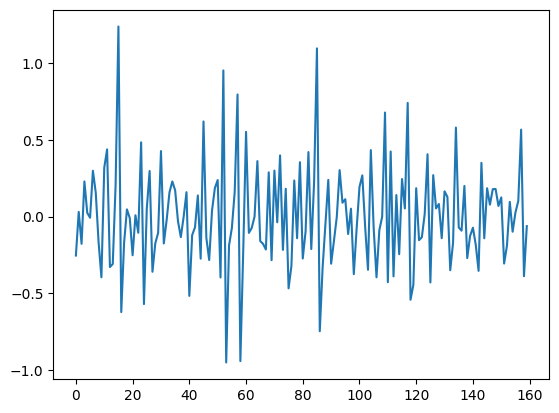

In [13]:
plt.plot(X[1, 1, :, 1])

In [14]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [0.00015512 0.00019105], std: [0.01668374 0.3446924 ]


In [15]:
dataset = InRAMDataset(X, y, timestamps = timestamps, asset_names = asset_names, transform=Scale(means, stds))

In [16]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=batch_size)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=batch_size)

In [17]:
sfm_model, a, b = get_model(load_weights=True)
sfm_model.to('cuda')

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

PatchedTimeSeriesDecoder(
  (input_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=64, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
  )
  (freq_emb): Embedding(3, 1280)
  (horizon_ff_layer): ResidualBlock(
    (hidden_layer): Sequential(
      (0): Linear(in_features=1280, out_features=1280, bias=True)
      (1): SiLU()
    )
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (stacked_transformer): StackedDecoder(
    (layers): ModuleList(
      (0-49): 50 x TimesFMDecoderLayer(
        (self_attn): TimesFMAttention(
          (qkv_proj): Linear(in_features=1280, out_features=3840, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (

In [18]:

from torch import dropout


class DeepNet(torch.nn.Module, Benchmark):
    def generate_square_subsequent_mask(self, sz):
        """生成因果掩码，sz 是目标序列长度"""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask
    def __init__(self, n_assets, lookback, channels, hidden_size = 128, p=0.4, max_weight=1., n_output_channels = 4):
        super().__init__()

        super().__init__()

        n_features =  patch_num * 128 # 输入特征数
        predict_patch_num = (horizon_len + 128 -1) // 128
        scale_ratio = 4
        self.CollapseChannel = Conv(n_input_channels=channels,
             n_output_channels=1,
             kernel_size=3,
             method='2D')
        
        self.embedding_layer_2 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.embedding_layer_1 = nn.Linear(n_assets*channels, n_assets*scale_ratio, bias=True)
        self.cross_embedding_layer = nn.Linear(896, n_assets*scale_ratio, bias=True)
        # 参数
        d_model = n_assets*scale_ratio  # 隐藏维度
        nhead = 2      # 注意力头数
        num_encoder_layers = 1  # 编码器层数
        num_decoder_layers = 2  # 解码器层数
        dim_feedforward = 16  # 前馈层中间维度
        dropout = 0.2
        self.encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.cross_decoder_layer = nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.cross_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.mask = self.generate_square_subsequent_mask(lookback).to('cuda')
        layers = []

        layers.append(nn.Linear(n_features, 1))
        layers.append(nn.ReLU())
        self.CollapseSFM = nn.Sequential(*layers)
        
        self.layer_L3 = AverageCollapse()
        self.layer_L4 = CovarianceMatrix(sqrt=False)
        self.layer_L5 = NumericalMarkowitz(n_assets)
        # Dropout 层
        self.dropout_layer = nn.Dropout(p=p)
        
        # 10 层网络
        layers = []
        # 第 1 层：输入层
        layers.append(nn.Linear(patch_num*1280, hidden_size))
        layers.append(nn.ReLU())
        
        
        # 将所有层组合成 Sequential
        self.network = nn.Sequential(*layers)
        self.dense_layer = torch.nn.Linear(n_assets*scale_ratio, n_assets, bias=True)
        self.dense_layer_2 = torch.nn.Linear(channels, 1, bias=True)
        
        # Softmax 分配层和温度参数
        self.allocate_layer = SoftmaxAllocator(temperature=None, n_assets= n_assets, formulation='variational', max_weight=1)
        self.temperature = nn.Parameter(torch.ones(1), requires_grad=True)
        

    def forward(self, x, timestamps=None, asset_names=None):

        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        # if timestamps is not None:
        #     script_features = []
        #     for timestamp in timestamps:
        #         script_f = get_values_before_date(mean_content, timestamp)[-200:]
        #         script_f = torch.stack(script_f, dim=0) # 200, 896
        #         script_features.append(script_f)
        #     script_tensor = torch.stack(script_features, dim=0)
        
        # script_tensor = script_tensor.to(device)
        # script_tensor = self.cross_embedding_layer(script_tensor)
        n_samples, channels, lookback, n_assets = x.shape
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(n_samples, n_assets*channels, lookback)
        m_list = [] 
        
        for i in range(n_samples):
            m = x[i, :,:]
            input_padding = torch.zeros_like(m).to(device)
            freq = torch.tensor([0], dtype=torch.long).to(device)
            with torch.no_grad():
                m = sfm_model(m, input_padding, freq) # B, patch_num, 128, 10 (mean +  9 quantiles)
            #m = sfm_model(m, input_padding, freq)
            m = m[:,:,:,0] # channels*n_assets, patch_num, 128
            m = m[:,-1,:] # B,  last patch predicted first patch's 128  prediction
            m_list.append(m)
        m = torch.stack(m_list, dim=0) # B, channels*n_assets, 128
        m = m[:,:,:horizon_len]
        m = m.permute(0,2,1) #B, horizon_len, n_assets*channels
        m = self.embedding_layer_1(m) #B, horizon_len, n_assets*sclale_ratio
        m = self.cross_decoder(m, m) #B, horizon_len, n_assets*sclale_ratio
        #m = m[:,-1,:]
        # m = m[:,:,0:horizon_len]  # B, channels*n_assets, horizon_len
        # m = m.permute(0,2,1) # B, horizon_len, channels*n_assets
        # m = self.embedding_layer_1(m) # B, horizon_len, n_assets*sclale_ratio
        # # m 不需要std化 
        x = x.permute(0, 2, 1) # B, lookback, n_assets*channels
        x = self.embedding_layer_2(x) # B, lookback, n_assets*sclale_ratio
        x = self.decoder(x, m, self.mask)
        x = x[:,-1, :]
        #x = x + m
        x = x.reshape(n_samples, -1)
        x = self.dense_layer(x) # B, lookback, n_assets*sclale_ratio
        # # #x = self.cross_decoder(x, script_tensor)
        # # x = self.decoder(m, x) # B, patch_num, n_assets*sclale_ratio
        # # #x = self.decoder(x, m) # B, lookback, n_assets*scale_ratio
        # # #x = x.permute(0, 2, 1)
        # x = self.decoder(m, m, self.mask) # B, horizon_len, n_assets*sclale_ratio
        #x = x.reshape(n_samples,  -1) #B, n_assets, horizon_len*scale_ratio
        #x = x[:,-1, :]
        
        
        #x = self.dropout_layer(x)
        #m = self.dense_layer_2(m)
        
        #x = self.dense_layer(x)
        x = x.squeeze(-1)
        # 计算权重
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [19]:
from deepdow.nn import BachelierNet

n_input_channels = len(channels)
max_weight = 1
hidden_size = 32
network = None


In [20]:
if True:
    #network = GreatNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
    network = DeepNet(n_assets, lookback, channels=n_channels, hidden_size=hidden_size,p=0.4)
else:
    network = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)


In [21]:
network

DeepNet(
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_2): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_1): Linear(in_features=60, out_features=120, bias=True)
  (cross_embedding_layer): Linear(in_features=896, out_features=120, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
    )
    (linear1): Linear(in_features=120, out_features=16, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=16, out_features=120, bias=True)
    (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): M

In [22]:
network_to_train = network.train() 

In [23]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio(rf=0.000)
#loss = MeanReturns()

In [24]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = DeepRun(network_to_train,
          loss,
          dataloader_train,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device
          )

#

In [ ]:
history = run.launch(7)

Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

In [51]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       28
                    OneOverN       -1       28
                    network         0       28
                                    1       28
                                    2       28
                                    3       28
                                    4       28
                                    5       28
                                    6       28
                                    7       28
                                    8       28
                                    9       28
                                    10      28
                                    11      28
                                    12      28
                                    13      28
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1      -0.037
                    OneOverN       -1      -0.164
                    network         0   

<Axes: xlabel='epoch'>

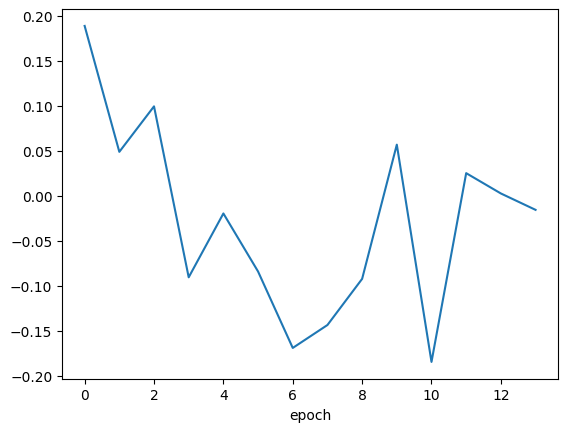

In [52]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [53]:
from json import load


loaded_network = torch.load('models/2025-04-19 09-26-16/model_10__-0.1844.pth', weights_only=False)
loaded_network.eval()

DeepNet(
  (CollapseChannel): Conv(
    (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (embedding_layer_2): Linear(in_features=60, out_features=120, bias=True)
  (embedding_layer_1): Linear(in_features=60, out_features=120, bias=True)
  (cross_embedding_layer): Linear(in_features=896, out_features=120, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
    )
    (linear1): Linear(in_features=120, out_features=16, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=16, out_features=120, bias=True)
    (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): M

In [54]:
network = network.eval()

In [55]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    'network': network,
    'best_network': loaded_network
}

In [56]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [57]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

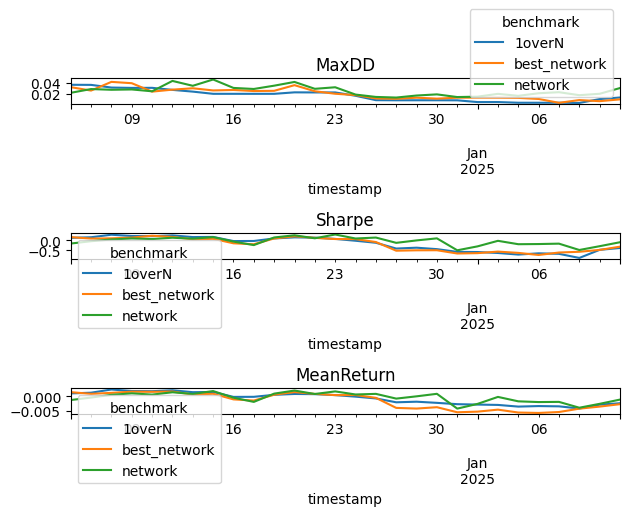

In [58]:
plot_metrics(metrics_table)

In [59]:
weight_table = generate_weights_table(network, dataloader_test,device = device)

<Axes: >

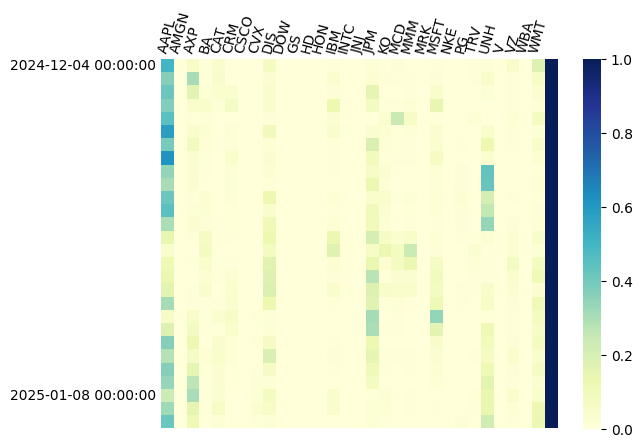

In [60]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

<Axes: >

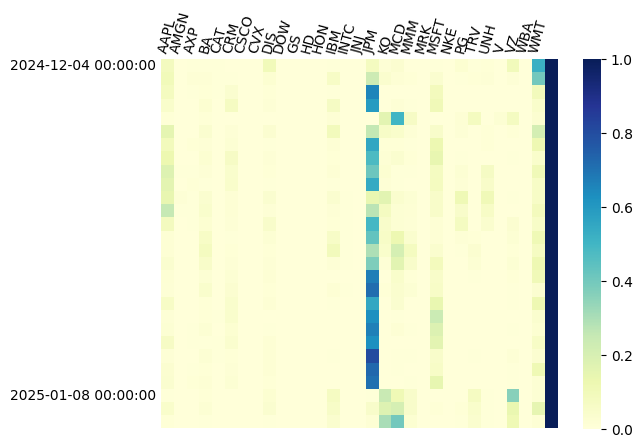

In [61]:
weight_table = generate_weights_table(loaded_network, dataloader_test,device = device)
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [62]:
pd.set_option('display.precision', 10)
print(weight_table)

            AAPL  AMGN   AXP    BA   CAT   CRM  CSCO   CVX   DIS   DOW  ...  \
2024-12-04 0.086 0.000 0.004 0.006 0.005 0.002 0.001 0.000 0.099 0.000  ...   
2024-12-05 0.098 0.000 0.012 0.015 0.006 0.005 0.001 0.000 0.026 0.000  ...   
2024-12-06 0.080 0.000 0.005 0.009 0.005 0.034 0.001 0.000 0.011 0.000  ...   
2024-12-09 0.045 0.000 0.001 0.025 0.003 0.071 0.001 0.000 0.012 0.000  ...   
2024-12-10 0.011 0.000 0.001 0.011 0.001 0.000 0.000 0.000 0.004 0.000  ...   
2024-12-11 0.155 0.000 0.004 0.035 0.001 0.015 0.001 0.000 0.031 0.000  ...   
2024-12-12 0.094 0.000 0.009 0.015 0.002 0.020 0.001 0.000 0.007 0.000  ...   
2024-12-13 0.127 0.000 0.003 0.025 0.001 0.065 0.001 0.000 0.015 0.000  ...   
2024-12-16 0.178 0.004 0.007 0.013 0.000 0.042 0.001 0.000 0.010 0.000  ...   
2024-12-17 0.160 0.002 0.009 0.006 0.001 0.044 0.001 0.000 0.006 0.000  ...   
2024-12-18 0.143 0.013 0.005 0.033 0.000 0.019 0.001 0.000 0.035 0.000  ...   
2024-12-19 0.253 0.007 0.006 0.040 0.000 0.018 0.001